<a href="https://colab.research.google.com/github/sanamsabooni/Thesis_ErrorDetection/blob/main/Thesis_ErrorDetection_A4988_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import os

In [2]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

directory_path = "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive


In [ ]:
#Skip if you are not combining .xlsx files

#setting directory path
#comment out one when we want to work on the other path

#A4988
#directory_path = "/content/drive/My Drive/Colab Notebooks/A4988SanamFormatOnly"
#TMC2209
directory_path = "/content/drive/My Drive/Colab Notebooks/TMC2209SanamFormatOnly"

#Building a list of the excel file from the directory path above
# List to store the files
file_list = []

# Loop through the directory and add .xlsx files to the list
for file in os.listdir(directory_path):
    if file.endswith(".xlsx"):
        file_list.append(file)
# Print the names of the files in the list
for file_name in file_list:
    print(file_name)


In [ ]:
#combine all .xlsx files in the specified directory into a single data frame
dfs = []

for file in os.listdir(directory_path):
    if file.endswith('.xlsx'):
        file_path = os.path.join(directory_path, file)
        df = pd.read_excel(file_path)
        dfs.append(df)

In [ ]:
#Save single(giant) data frame as csv
giant_df = pd.concat(dfs, ignore_index=True)
giant_file_path = os.path.join(directory_path, 'A4988.csv')
giant_df.to_csv(giant_file_path, index=False)

In [9]:
# Setting the path name to the csv
file_name = "A4988.csv"

/content/A4988.csv


In [3]:
##########################################################################################################################
################################## start from here if you are not combining .xlsx files ##################################
##########################################################################################################################
data_b = pd.read_csv('/content/drive/My Drive/Colab Notebooks/A4988.csv')

In [4]:
#Data shape, types, description
print(data_b.shape)
print(data_b.dtypes)
print(data_b.describe())

(4807481, 6)
commanded position      float64
theoretical position    float64
actual position         float64
error actual            float64
error theoretical       float64
time                    float64
dtype: object
       commanded position  theoretical position  actual position  \
count        4.807481e+06          4.807481e+06     4.807481e+06   
mean         7.609880e+01          7.592729e+01     7.611644e+01   
std          7.814813e+01          7.814481e+01     7.815612e+01   
min         -2.500000e-02         -3.112793e-01    -1.200000e-02   
25%          1.998438e+01          1.969177e+01     1.999500e+01   
50%          4.568125e+01          4.562622e+01     4.570300e+01   
75%          1.000000e+02          9.969543e+01     1.000430e+02   
max          3.000000e+02          3.000055e+02     3.000120e+02   

       error actual  error theoretical          time  
count  4.807481e+06       4.807481e+06  4.807481e+06  
mean   1.764020e-02      -1.715076e-01  6.433841e+01  
std

In [5]:
#data preprocessing
# Dropping "time" and error "theoretical columns"
for i in range(2):
    data_b.drop(data_b.columns[len(data_b.columns)-1], axis=1, inplace = True)

In [6]:
# rename error actual as error(output)
datab = data_b.rename(columns={'error actual':'error'}, inplace=True)

In [7]:
#printing the head and tail of the table
# plus 2-d instribution
data_b = data_b.sample(frac=0.1, random_state=42)

In [8]:
#cleaning data
# Drop the row where 'error' is 32.77
data_b = data_b[data_b['error'] <= 20]

In [9]:
# Extract the features (X) and target (Y) for ballscrew
X_b = data_b.iloc[:, :-1].values  # Use all columns except the last one as features
Y_b = data_b.iloc[:, -1].values  # Use the last column as the target

In [10]:
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(X_b, Y_b, test_size=0.2, random_state=42)

In [11]:
# Checking skewness
check_skew = (data_b.skew(axis=0, skipna=True, numeric_only=True))
print(check_skew)

commanded position      1.356775
theoretical position    1.356954
actual position         1.356371
error                   0.237856
dtype: float64


In [12]:
# Standardization
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
fit = std_scaler.fit(data_b)
output = std_scaler.transform(data_b)
data_b = pd.DataFrame(output, columns=data_b.columns, index=list(data_b.index.values))

In [13]:
def detect_outlier(column):
    """
    Detects outliers in a pandas series and returns their indices.
    """
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    return column[(column < lower_bound) | (column > upper_bound)].index

# List to hold indices of rows with outliers
outlier_indices = []

# Detecting outliers in each column and adding their indices to the list
for i in data_b.columns:
    outlier_idx = detect_outlier(data_b[i])
    outlier_indices.extend(outlier_idx)

# Removing duplicates in the list of indices
outlier_indices = list(set(outlier_indices))

# Deleting rows with outliers
data_b = data_b.drop(outlier_indices)

In [14]:
# Checking outliers
for feature in data_b.columns:
    outlier = detect_outlier(data_b[feature])
    print('Name of column: '+ feature)
    print('Number of outliers: '+ str(len(outlier)))
    print('Max outlier value: '+ str(outlier.max()))
    print('Min outlier value: '+ str(outlier.min()))
    print('\n')

Name of column: commanded position
Number of outliers: 26827
Max outlier value: 4331322
Min outlier value: 1139033


Name of column: theoretical position
Number of outliers: 27045
Max outlier value: 4331322
Min outlier value: 1138941


Name of column: actual position
Number of outliers: 26800
Max outlier value: 4331315
Min outlier value: 1139054


Name of column: error
Number of outliers: 4
Max outlier value: 3356414
Min outlier value: 3085376




In [15]:
# Normalize the data
scaler_X_b = MinMaxScaler()
scaler_Y_b = MinMaxScaler()
X_b = scaler_X_b.fit_transform(X_b)
Y_b = scaler_Y_b.fit_transform(Y_b.reshape(-1, 1))

In [16]:
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(X_b, Y_b, test_size=0.2, random_state=42)

Epoch 1/50
9615/9615 [==============================] - 29s 3ms/step - loss: 0.0202 - val_loss: 0.0125
Epoch 2/50
9615/9615 [==============================] - 28s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 3/50
9615/9615 [==============================] - 26s 3ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 4/50
9615/9615 [==============================] - 27s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 5/50
9615/9615 [==============================] - 28s 3ms/step - loss: 0.0125 - val_loss: 0.0126
Epoch 6/50
9615/9615 [==============================] - 29s 3ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 7/50
9615/9615 [==============================] - 25s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 8/50
9615/9615 [==============================] - 28s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 9/50
9615/9615 [==============================] - 28s 3ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 10/50
9615/9615 [==============================] - 28s 3ms/step - l

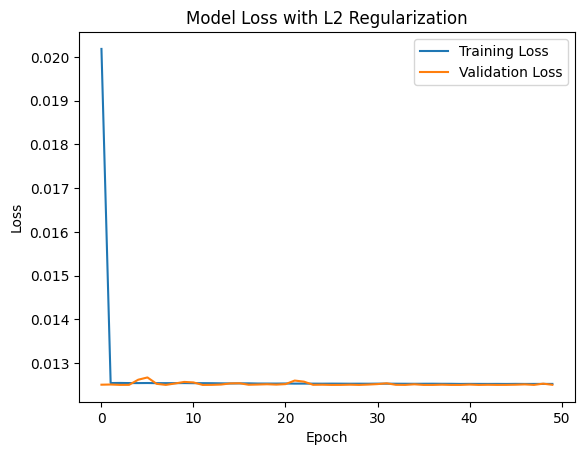

In [19]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.regularizers import l2

# Define the neural network with L2 regularization
model = Sequential()
model.add(Dense(8, input_dim=X_b.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(12, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='linear'))  # Assuming it's a regression task with one output

# Compile the model with a specific learning rate
custom_optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=custom_optimizer)

# Train the model and save the history
# epoch 10 was overtraining the model, 8 would be the best
history = model.fit(X_train_b, Y_train_b, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Plotting the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with L2 Regularization')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [22]:
# Split data into training and testing sets
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(X_b, Y_b, test_size=0.2, random_state=42)

Epoch 1/50
9615/9615 [==============================] - 39s 4ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 2/50
9615/9615 [==============================] - 28s 3ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 3/50
9615/9615 [==============================] - 32s 3ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 4/50
9615/9615 [==============================] - 30s 3ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 5/50
9615/9615 [==============================] - 29s 3ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 6/50
9615/9615 [==============================] - 28s 3ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 7/50
9615/9615 [==============================] - 32s 3ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 8/50
9615/9615 [==============================] - 32s 3ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 9/50
9615/9615 [==============================] - 31s 3ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 10/50
9615/9615 [==============================] - 29s 3ms/step - l

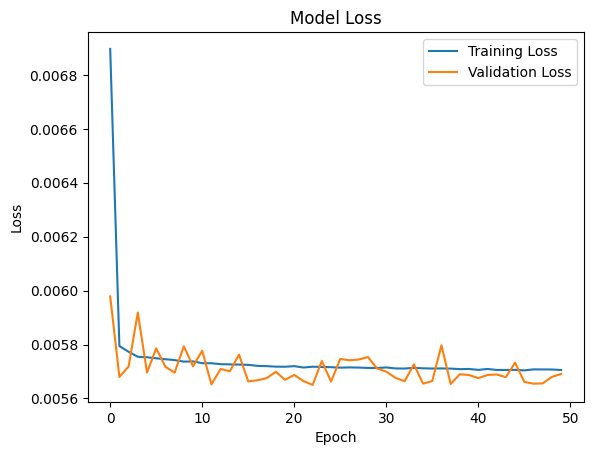

In [25]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define the neural network
model = Sequential()
model.add(Dense(8, input_dim=X_b.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))  # Assuming it's a regression task with one output

# Compile the model with a specific learning rate
custom_optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=custom_optimizer)

# Train the model and save the history
# epoch 10 was overtraining the model, 8 would be the best
history = model.fit(X_train_b, Y_train_b, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Plotting the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [26]:
# Evaluate the model
MSE_train_b = np.mean(np.square(model.predict(X_train_b) - Y_train_b))
MSE_test_b = np.mean(np.square(model.predict(X_test_b) - Y_test_b))
print('MSE on training data:', MSE_train_b)
print('MSE on testing data:', MSE_test_b)

3005/3005 [==============================] - 5s 2ms/step
MSE on training data: 0.0057111799332085515
MSE on testing data: 0.005726013789784838


In [ ]:
data_b.shape

(4349161, 4)

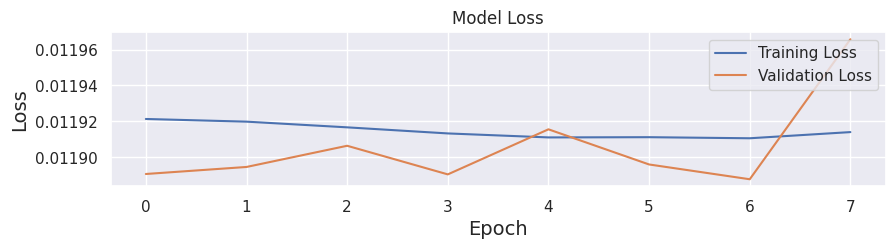

In [ ]:
# Plotting the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Epoch 1/4
96150/96150 [==============================] - 291s 3ms/step - loss: 0.0139 - val_loss: 0.0119
Epoch 2/4
96150/96150 [==============================] - 273s 3ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 3/4
96150/96150 [==============================] - 273s 3ms/step - loss: 0.0119 - val_loss: 0.0120
Epoch 4/4
96150/96150 [==============================] - 269s 3ms/step - loss: 0.0119 - val_loss: 0.0119


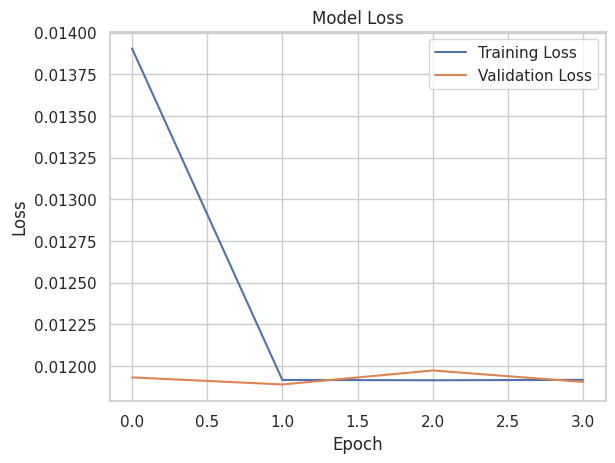

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l1

# Define the neural network with L1 regularization
model = Sequential()
model.add(Dense(8, input_dim=X_b.shape[1], activation='tanh', kernel_regularizer=l1(0.01)))
model.add(Dense(10, activation='tanh', kernel_regularizer=l1(0.01)))
model.add(Dense(12, activation='tanh', kernel_regularizer=l1(0.01)))
model.add(Dense(8, activation='tanh', kernel_regularizer=l1(0.01)))
model.add(Dense(1, activation='tanh', kernel_regularizer=l1(0.01)))  # Assuming it's a regression task with one output

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and save the history
history = model.fit(X_train_b, Y_train_b, epochs=4, batch_size=32, verbose=1, validation_split=0.2)

# Plotting the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Evaluate the model
MSE_train_b = np.mean(np.square(model.predict(X_train_b) - Y_train_b))
MSE_test_b = np.mean(np.square(model.predict(X_test_b) - Y_test_b))
print('MSE on training data:', MSE_train_b)
print('MSE on testing data:', MSE_test_b)

30047/30047 [==============================] - 52s 2ms/step
MSE on training data: 0.011546770718116292
MSE on testing data: 0.011529016555679469


In [ ]:
# Extract the features (X) and target (Y)
X_l = data_l.iloc[:, :-1].values
Y_l = data_l.iloc[:, -1].values

NameError: ignored

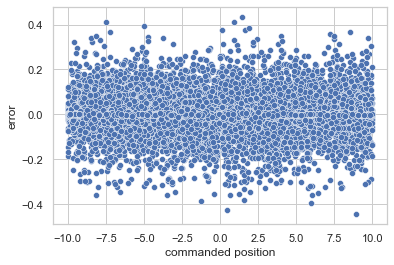

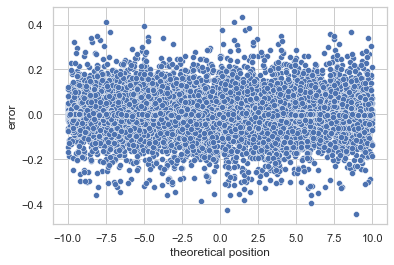

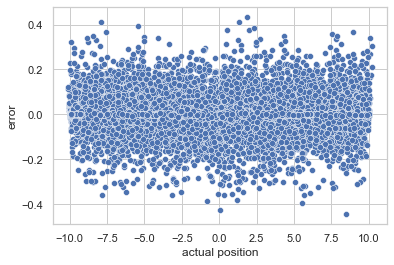

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn styles for the plots
sns.set_theme(style="whitegrid")

# Scatter plot for each feature against the target variable "error"
# Feature: "commanded position" vs "error"
sns.scatterplot(x=data_l['commanded position'], y=data_l['error'])
plt.show()

# Feature: "theoretical position" vs "error"
sns.scatterplot(x=data_l['theoretical position'], y=data_l['error'])
plt.show()

# Feature: "actual position" vs "error"
sns.scatterplot(x=data_l['actual position'], y=data_l['error'])
plt.show()


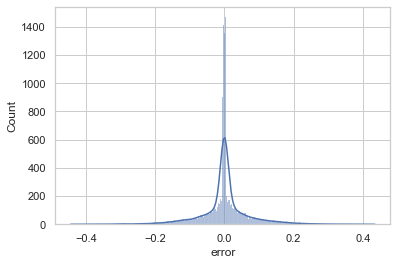

In [ ]:
#Histogram
sns.histplot(data_l['error'], kde=True)
plt.show()

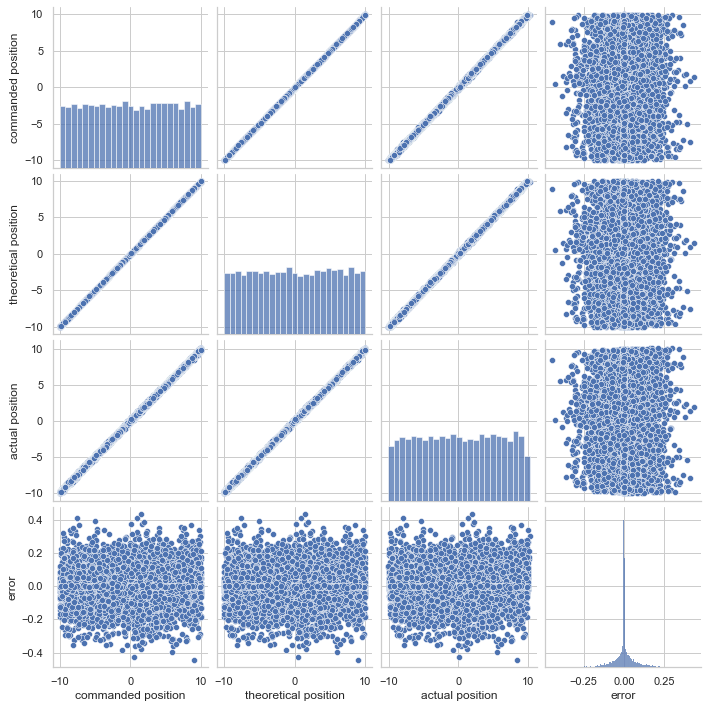

In [ ]:
# Seaborn Pair Plot
sns.pairplot(data_l)
plt.show()

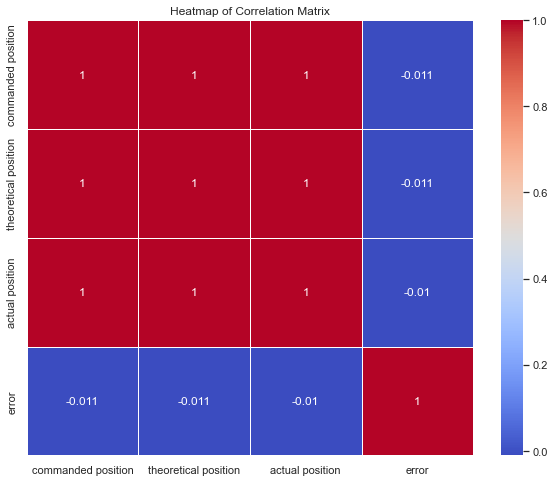

In [ ]:
# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = data_l.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [ ]:
# Normalize the data
scaler_X_l = MinMaxScaler()
scaler_Y_l = MinMaxScaler()
X_l = scaler_X_l.fit_transform(X_l)
Y_l = scaler_Y_l.fit_transform(Y_l.reshape(-1, 1))

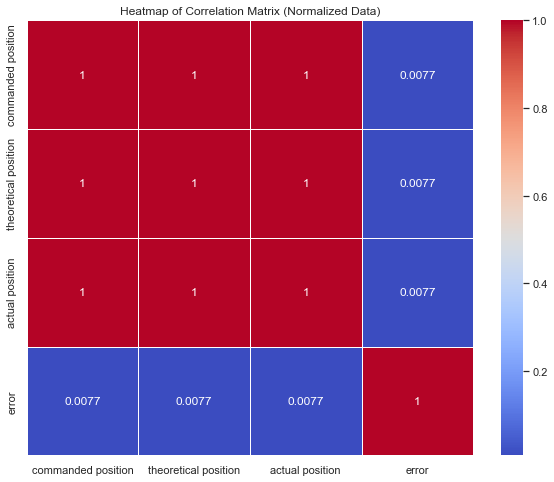

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the features (Note that we are not normalizing the target variable 'error')
data_b_normalized = pd.DataFrame(scaler.fit_transform(data_b.iloc[:, :-1]), columns=data_b.columns[:-1])

# Add the target variable 'error' back into the DataFrame
data_b_normalized['error'] = data_b['error'].values

# Now let's visualize the normalized data with a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix_normalized = data_b_normalized.corr()
sns.heatmap(correlation_matrix_normalized, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Correlation Matrix (Normalized Data)')
plt.show()


In [ ]:
# Scatter Plot for each feature against the target on normalized data
for feature in features:
    sns.scatterplot(data=data_b_normalized, x=feature, y=target)
    plt.title(f'Scatter Plot of {feature} vs {target} (Normalized Data)')
    plt.show()

# Pair Plot on normalized data
sns.pairplot(data_b_normalized)
plt.show()

In [ ]:
# Split data into training and testing sets
X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(X_l, Y_l, test_size=0.2, random_state=42)

In [ ]:
# Define the neural network
model = Sequential()
model.add(Dense(8, input_dim=X_l.shape[1], activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='tanh'))  # Assuming it's a regression task with one output

In [ ]:
# Define the neural network
model = Sequential()
model.add(Dense(8, input_dim=X_l.shape[1], activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(12, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='tanh'))  # Assuming it's a regression task with one output

In [ ]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Train the model
model.fit(X_train_l, Y_train_l, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
375/375 [==============================] - 2s 2ms/step - loss: 0.0097
Epoch 2/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 5/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 8/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 9/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 10/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 11/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 12/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 13/100


In [ ]:
# Evaluate the model
MSE_train_l = np.mean(np.square(model.predict(X_train_l) - Y_train_l))
MSE_test_l = np.mean(np.square(model.predict(X_test_l) - Y_test_l))
print('MSE on training data:', MSE_train_l)
print('MSE on testing data:', MSE_test_l)

94/94 [==============================] - 0s 1ms/step
MSE on training data: 0.00017921019807527432
MSE on testing data: 0.00016127370395259326


In [ ]:
!pip install google-cloud-bigquery

In [ ]:
!pip install pandas-gbq

   ---------------------------------------- 190.9/190.9 kB 3.8 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.11.0 requires google-auth-oauthlib<0.5,>=0.4.1, but you have google-auth-oauthlib 1.1.0 which is incompatible.
tensorboard 2.11.0 requires protobuf<4,>=3.9.2, but you have protobuf 4.25.1 which is incompatible.
tensorflow-intel 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.25.1 which is incompatible.


   ---------------------------------------- 24.6/24.6 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6


In [ ]:
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.oauth2 import service_account

# Replace 'your_project' and 'your_dataset' with your project ID and dataset ID
project_id = 'level-footing-406016'
dataset_id = 'level-footing-406016.file1_sample_ds'

# Replace 'your_table' with your table ID
table_id = 'samples'

# Replace 'path/to/your/csv/file.csv' with the path to your CSV file
excel_file_path = 'C:\\Users\\Sanam\\Downloads\\A4988SanamFormatOnly\\A4988SanamFormatOnly\\Jupyter_BS_1_A4988_1_5.0mm_12rpm_4000rpms_.xlsx'

# Read xlsx file
df = pd.read_excel(excel_file_path)

# Save the DataFrame to a CSV file
csv_file_path = 'C:\\Users\\Sanam\\Downloads\\A4988SanamFormatOnly\\A4988SanamFormatOnly\\Jupyter_BS_1_A4988_1_5.0mm_12rpm_4000rpms_.csv'
df.to_csv(csv_file_path, index=False)

# Replace 'path/to/your/credentials.json' with the actual path to your JSON key file
credentials_path = 'C:\\Users\\Sanam\\Downloads\\level-footing-406016-0b81de67bdd9.json'

# Explicitly create credentials
credentials = service_account.Credentials.from_service_account_file(credentials_path)

# Set up the BigQuery client with explicit credentials
client = bigquery.Client(credentials=credentials)

# Get the reference to the destination table
table_ref = f"{project_id}.{dataset_id}.{table_id}"

# Write the DataFrame to BigQuery
df.to_gbq(destination_table=table_ref, project_id=project_id, if_exists='append')

print(f"Data loaded to {table_ref.project}.{table_ref.dataset_id}.{table_ref.table_id}")

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fpydata-google-auth.readthedocs.io%2Fen%2Flatest%2Foauth.html&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=oegEo9RRVuKQXfrkwHDec1QB2U7FHL&prompt=consent&access_type=offline


KeyboardInterrupt: Interrupted by user